In [384]:
import sys
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, HiveContext
import os
from pyspark.sql.functions import *
from pyspark.sql import functions as sqlf 
import pyspark.storagelevel 
import numpy as np
import pandas as pd
import datetime
from pyspark.sql.types import *
import pdb
import subprocess # Used for executing linux commands, for writing to teradata
import sys

from pyspark.sql.types import *
from pyspark.sql.functions import col, udf, min, max
from datetime import datetime, timedelta
conf = SparkConf().setMaster("local").setAppName("storeSales")
sc = SparkContext.getOrCreate(conf = conf)
sqlContext = SQLContext(sc)
hiveContext = HiveContext(sc)

In [385]:
from pyspark.sql.types import *
data_fields = StructType([StructField("_ID", IntegerType(), True),
       StructField("TimeSt", StringType(), True),
       StructField("Country", StringType(), True),
       StructField("Province", StringType(), True),
       StructField("City", StringType(), True),
       StructField("Latitude", FloatType(), True),
       StructField("Longitude", FloatType(), True)])
poi_fields = StructType([StructField("POIID", StringType(), True),
       StructField("Latitude", FloatType(), True),
       StructField("Longitude", FloatType(), True)])

In [386]:
data_sample = hiveContext.read.format("com.databricks.spark.csv") \
  .option("header", "true") \
  .option("inferSchema", "true") \
  .load("file:///home/vijay/DATA_SCIENCE/BPF/BPF/work-samples-master/data-mr/data/DataSample.csv",schema=data_fields)
poi_df = hiveContext.read.format("com.databricks.spark.csv") \
  .option("header", "true") \
  .option("inferSchema", "true") \
  .load("file:///home/vijay/DATA_SCIENCE/BPF/BPF/work-samples-master/data-mr/data/POIList.csv",schema=poi_fields)

In [387]:
data_sample.show(4)

+-------+--------------------+-------+--------+---------+--------+---------+
|    _ID|              TimeSt|Country|Province|     City|Latitude|Longitude|
+-------+--------------------+-------+--------+---------+--------+---------+
|4516516|2017-06-21 00:00:...|     CA|      ON| Waterloo|43.49347|-80.49123|
|4516547|2017-06-21 18:00:...|     CA|      ON|   London| 42.9399| -81.2709|
|4516550|2017-06-21 15:00:...|     CA|      ON|   Guelph| 43.5776| -80.2201|
|4516600|2017-06-21 15:00:...|     CA|      ON|Stratford| 43.3716| -80.9773|
+-------+--------------------+-------+--------+---------+--------+---------+
only showing top 4 rows



In [388]:
pd_df = data_sample.toPandas()

In [389]:
pd_df.describe()

,_ID,Latitude,Longitude
count,2.202500e+04,22025.000000,22025.000000
mean,5.067292e+06,47.983484,-94.967281
std,3.175577e+05,4.165093,19.092001
min,4.516516e+06,6.927420,-136.539566
25%,4.792159e+06,43.747601,-113.814003
50%,5.067906e+06,47.798698,-83.017998
75%,5.342586e+06,51.128559,-79.399101
max,5.615006e+06,62.827301,125.702202


In [390]:
pd_df[['Country','Province','City','TimeSt']].describe()

,Country,Province,City,TimeSt
count,22025,22025,22025,22025
unique,1,12,656,19972
top,CA,ON,Calgary,2017-06-21 06:11:00.323
freq,22025,9321,3979,3


In [391]:
# There are duplicate TimeSt, City, Province

In [392]:
data_sample.registerTempTable("data_sample_table")

In [393]:
unique_data_sample = hiveContext.sql( '''select Max(_ID) as ID, TimeSt, Latitude, Longitude,concat(Latitude,',',Longitude) as Coordinates,Country,Province,City
                                 from data_sample_table group by TimeSt, Latitude, Longitude,Country,Province,City 
                                 order by 
                                 TimeSt,
                                 Latitude,
                                 Longitude''' )

In [394]:
unique_data_sample.count()

19999

In [395]:
unique_data_sample.show(10)

+-------+--------------------+--------+---------+------------------+-------+--------+---------+
|     ID|              TimeSt|Latitude|Longitude|       Coordinates|Country|Province|     City|
+-------+--------------------+--------+---------+------------------+-------+--------+---------+
|4516516|2017-06-21 00:00:...|43.49347|-80.49123|43.49347,-80.49123|     CA|      ON| Waterloo|
|4519209|2017-06-21 00:00:...| 44.1517| -81.0266|  44.1517,-81.0266|     CA|      ON|  Hanover|
|4518130|2017-06-21 00:00:...| 43.0004| -81.2343|  43.0004,-81.2343|     CA|      ON|   London|
|5368841|2017-06-21 00:00:...| 45.2778| -75.7563|  45.2778,-75.7563|     CA|      ON|   Nepean|
|4521574|2017-06-21 00:00:...| 43.1508| -80.2094|  43.1508,-80.2094|     CA|      ON|Brantford|
|4523455|2017-06-21 00:00:...| 43.0091| -81.1765|  43.0091,-81.1765|     CA|      ON|   London|
|4522231|2017-06-21 00:00:...| 42.4247| -82.1755|  42.4247,-82.1755|     CA|      ON|  Chatham|
|4522376|2017-06-21 00:00:...| 43.4634| 

In [396]:
poi_df.show()

+-----+---------+----------+
|POIID| Latitude| Longitude|
+-----+---------+----------+
| POI1|53.546165|-113.48573|
| POI2|53.546165|-113.48573|
| POI3| 45.52163|-73.566025|
| POI4| 45.22483| -63.23273|
+-----+---------+----------+



#poi_df= hiveContext.sql("SELECT POIID,Latitude,Longitude,CONCAT(Latitude,',',Longitude) AS Coordinates FROM poi_df")
Coordinates_df = poi_df.select(concat(poi_df['Latitude'], lit(','),poi_df['Longitude']).alias('Coordinates'),poi_df['POIID'])
Coordinates_df.show()

poi_df_coords = poi_df.join(Coordinates_df, on = "POIID", how = "inner" )

poi_df_coords.show()

In [397]:
setA_lat = np.array(unique_data_sample.select('Latitude').collect())
setA_lon = np.array(unique_data_sample.select('Longitude').collect())

In [398]:
setB_lat = np.array(poi_df.select('Latitude').collect())
setB_lon = np.array(poi_df.select('Longitude').collect())

In [399]:
setA = np.c_[setA_lat,setA_lon]
setA

array([[  43.49346924,  -80.4912262 ],
       [  44.15169907,  -81.0266037 ],
       [  43.00040054,  -81.23429871],
       ..., 
       [  53.49723053, -113.63462067],
       [  43.77030182,  -79.21649933],
       [  49.78279877,  -94.44110107]])

In [400]:
setB = np.c_[setB_lat,setB_lon]
setB

array([[  53.54616547, -113.48573303],
       [  53.54616547, -113.48573303],
       [  45.52162933,  -73.56602478],
       [  45.22483063,  -63.23273087]])

In [401]:
from scipy.spatial import cKDTree

def closest_pts(setA, setB):
    dst,indx = cKDTree(setB).query(setA,k=1,p=2)
    #print(indx[0:100])
    return setB[indx],dst

In [402]:
c_x, dst = closest_pts(setA, setB)

In [403]:
c_x[0:5]

array([[ 45.52162933, -73.56602478],
       [ 45.52162933, -73.56602478],
       [ 45.52162933, -73.56602478],
       [ 45.52162933, -73.56602478],
       [ 45.52162933, -73.56602478]])

In [404]:
dst[0:5]

array([ 7.2160826 ,  7.58531125,  8.0721137 ,  2.20380711,  7.05373826])

In [405]:
c_x.shape

(19999, 2)

In [406]:
columns = ['POI_nearest_lat','POI_nearest_lon']
c_x = pd.DataFrame(c_x,columns=columns)

In [407]:
unique_data_sample_pd = unique_data_sample.toPandas()
nearest_match_pd = nearest_match.toPandas()

In [408]:
unique_data_sample_pd['POI_nearest_lat'] = nearest_match_pd['nearest_lat']
unique_data_sample_pd['POI_nearest_lon'] = nearest_match_pd['nearest_lon']
unique_data_sample_pd['euclidean_dst'] = pd.Series(dst)

In [409]:
unique_data_sample_pd[0:5]

,ID,TimeSt,Latitude,Longitude,Coordinates,Country,Province,City,POI_nearest_lat,POI_nearest_lon,euclidean_dst
0,4516516,2017-06-21 00:00:00.143,43.493469,-80.491226,"43.49347,-80.49123",CA,ON,Waterloo,45.521629,-73.566025,7.216083
1,4519209,2017-06-21 00:00:01.257,44.151699,-81.026604,"44.1517,-81.0266",CA,ON,Hanover,45.521629,-73.566025,7.585311
2,4518130,2017-06-21 00:00:01.333,43.000401,-81.234299,"43.0004,-81.2343",CA,ON,London,45.521629,-73.566025,8.072114
3,5368841,2017-06-21 00:00:02.573,45.277802,-75.756302,"45.2778,-75.7563",CA,ON,Nepean,45.521629,-73.566025,2.203807
4,4521574,2017-06-21 00:00:02.637,43.150799,-80.209396,"43.1508,-80.2094",CA,ON,Brantford,45.521629,-73.566025,7.053738


In [410]:
unique_data_sample = hiveContext.createDataFrame(unique_data_sample_pd)

In [411]:
unique_data_sample.show(5)

+-------+--------------------+------------------+------------------+------------------+-------+--------+---------+------------------+------------------+------------------+
|     ID|              TimeSt|          Latitude|         Longitude|       Coordinates|Country|Province|     City|   POI_nearest_lat|   POI_nearest_lon|     euclidean_dst|
+-------+--------------------+------------------+------------------+------------------+-------+--------+---------+------------------+------------------+------------------+
|4516516|2017-06-21 00:00:...| 43.49346923828125|-80.49122619628906|43.49347,-80.49123|     CA|      ON| Waterloo|45.521629333496094|-73.56602478027344| 7.216082595439627|
|4519209|2017-06-21 00:00:...| 44.15169906616211|-81.02660369873047|  44.1517,-81.0266|     CA|      ON|  Hanover|45.521629333496094|-73.56602478027344|7.5853112484513945|
|4518130|2017-06-21 00:00:...| 43.00040054321289|-81.23429870605469|  43.0004,-81.2343|     CA|      ON|   London|45.521629333496094|-73.566

In [412]:
analysis_df = unique_data_sample.select('POI_nearest_lat','POI_nearest_lon','euclidean_dst')

In [413]:
analysis_df.show(10)

+------------------+------------------+------------------+
|   POI_nearest_lat|   POI_nearest_lon|     euclidean_dst|
+------------------+------------------+------------------+
|45.521629333496094|-73.56602478027344| 7.216082595439627|
|45.521629333496094|-73.56602478027344|7.5853112484513945|
|45.521629333496094|-73.56602478027344| 8.072113701736955|
|45.521629333496094|-73.56602478027344|2.2038071101603895|
|45.521629333496094|-73.56602478027344|7.0537382576079874|
|45.521629333496094|-73.56602478027344| 8.014493320368777|
|45.521629333496094|-73.56602478027344| 9.149535863508097|
|45.521629333496094|-73.56602478027344| 7.252276250332547|
|45.521629333496094|-73.56602478027344| 7.230630291757394|
|45.521629333496094|-73.56602478027344| 6.804583247944665|
+------------------+------------------+------------------+
only showing top 10 rows



In [585]:
analysis_df.registerTempTable("analysis_table")

In [586]:
average_distance_sample = hiveContext.sql( '''select POI_nearest_lat, POI_nearest_lon, avg(euclidean_dst) as average_dist
                                 from analysis_table group by POI_nearest_lat, POI_nearest_lon
                                 order by 
                                 POI_nearest_lat''' )

In [587]:
average_distance_sample.show(5)

+------------------+-------------------+------------------+
|   POI_nearest_lat|    POI_nearest_lon|      average_dist|
+------------------+-------------------+------------------+
|45.224830627441406|-63.232730865478516| 8.810410437140796|
|45.521629333496094| -73.56602478027344|5.5379502811404695|
|53.546165466308594|-113.48573303222656|  3.34818233218623|
+------------------+-------------------+------------------+



In [588]:
avg_stdv_dstnce_sample = hiveContext.sql( '''select 
                                              POI_nearest_lat,
                                              POI_nearest_lon,
                                              avg(euclidean_dst) as average_dist,
                                              stddev_pop(euclidean_dst) as stdev_dist,
                                              count(euclidean_dst) as density
                                 from analysis_table group by POI_nearest_lat, POI_nearest_lon
                                 order by 
                                 POI_nearest_lat ''' )

In [589]:
avg_stdv_dstnce_sample.show(5)

+------------------+-------------------+------------------+------------------+-------+
|   POI_nearest_lat|    POI_nearest_lon|      average_dist|        stdev_dist|density|
+------------------+-------------------+------------------+------------------+-------+
|45.224830627441406|-63.232730865478516| 8.810410437140796|28.645492353009296|    484|
|45.521629333496094| -73.56602478027344|5.5379502811404695| 2.858544053873327|   9817|
|53.546165466308594|-113.48573303222656|  3.34818233218623|3.8582907094762997|   9698|
+------------------+-------------------+------------------+------------------+-------+



In [590]:
a= avg_stdv_dstnce_sample.select(sum('density')).collect()
total_count = a[0][0]

In [591]:
avg_stdv_dstnce_sample.select('POI_nearest_lat','POI_nearest_lon','average_dist','stdev_dist','density').show()

+------------------+-------------------+------------------+------------------+-------+
|   POI_nearest_lat|    POI_nearest_lon|      average_dist|        stdev_dist|density|
+------------------+-------------------+------------------+------------------+-------+
|45.224830627441406|-63.232730865478516| 8.810410437140796|28.645492353009296|    484|
|45.521629333496094| -73.56602478027344|5.5379502811404695| 2.858544053873327|   9817|
|53.546165466308594|-113.48573303222656|  3.34818233218623|3.8582907094762997|   9698|
+------------------+-------------------+------------------+------------------+-------+



In [592]:
avg_stdv_dstnce_sample = avg_stdv_dstnce_sample.withColumn('density_pcnt', avg_stdv_dstnce_sample.density/total_count)

In [593]:
avg_stdv_dstnce_sample.show()

+------------------+-------------------+------------------+------------------+-------+--------------------+
|   POI_nearest_lat|    POI_nearest_lon|      average_dist|        stdev_dist|density|        density_pcnt|
+------------------+-------------------+------------------+------------------+-------+--------------------+
|45.224830627441406|-63.232730865478516| 8.810410437140796|28.645492353009296|    484|0.024201210060503024|
|45.521629333496094| -73.56602478027344|5.5379502811404695| 2.858544053873327|   9817| 0.49087454372718636|
|53.546165466308594|-113.48573303222656|  3.34818233218623|3.8582907094762997|   9698|  0.4849242462123106|
+------------------+-------------------+------------------+------------------+-------+--------------------+



In [594]:
avg_stdv_dstnce_sample_pd = avg_stdv_dstnce_sample.toPandas()

In [595]:
avg_stdv_dstnce_sample_pd['POIID'] = pd.Series(['POI4','POI3','POI2'])

In [596]:
avg_stdv_dstnce_sample_pd

,POI_nearest_lat,POI_nearest_lon,average_dist,stdev_dist,density,density_pcnt,POIID
0,45.224831,-63.232731,8.810410,28.645492,484,0.024201,POI4
1,45.521629,-73.566025,5.537950,2.858544,9817,0.490875,POI3
2,53.546165,-113.485733,3.348182,3.858291,9698,0.484924,POI2


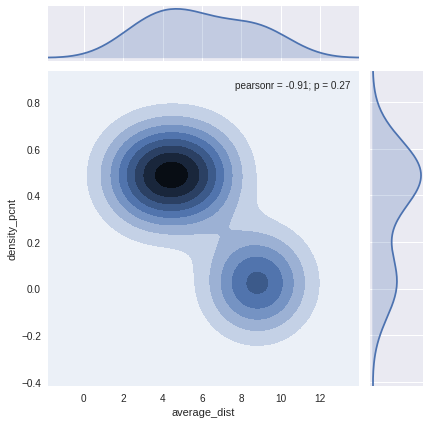

In [597]:
density_plot = avg_stdv_dstnce_sample_pd[['average_dist','density_pcnt']]
sns.jointplot(density_plot.average_dist,density_plot.density_pcnt,kind="kde",n_levels=10)

In [ ]:
#try

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(df.x, df.y, ax=ax)
sns.rugplot(df.x, color="g", ax=ax)
sns.rugplot(df.y, vertical=True, ax=ax);

In [421]:
unique_data_sample_pd['DATA_Coordinates'] = unique_data_sample_pd[['Latitude','Longitude']].values.tolist()

In [422]:
unique_data_sample_pd['POI_Coordinates'] = unique_data_sample_pd[['POI_nearest_lat','POI_nearest_lon']].values.tolist()

In [425]:
unique_data_sample_pd_df = unique_data_sample_pd[['DATA_Coordinates','Latitude','Longitude','City','POI_Coordinates','POI_nearest_lat','POI_nearest_lon','euclidean_dst']]

In [426]:
unique_data_sample_pd_df

,DATA_Coordinates,Latitude,Longitude,City,POI_Coordinates,POI_nearest_lat,POI_nearest_lon,euclidean_dst
0,"[43.4934692383, -80.4912261963]",43.493469,-80.491226,Waterloo,"[45.5216293335, -73.5660247803]",45.521629,-73.566025,7.216083
1,"[44.1516990662, -81.0266036987]",44.151699,-81.026604,Hanover,"[45.5216293335, -73.5660247803]",45.521629,-73.566025,7.585311
2,"[43.0004005432, -81.2342987061]",43.000401,-81.234299,London,"[45.5216293335, -73.5660247803]",45.521629,-73.566025,8.072114
3,"[45.2778015137, -75.7563018799]",45.277802,-75.756302,Nepean,"[45.5216293335, -73.5660247803]",45.521629,-73.566025,2.203807
4,"[43.1507987976, -80.2093963623]",43.150799,-80.209396,Brantford,"[45.5216293335, -73.5660247803]",45.521629,-73.566025,7.053738
5,"[43.0091018677, -81.1764984131]",43.009102,-81.176498,London,"[45.5216293335, -73.5660247803]",45.521629,-73.566025,8.014493
6,"[42.4247016907, -82.1754989624]",42.424702,-82.175499,Chatham,"[45.5216293335, -73.5660247803]",45.521629,-73.566025,9.149536
7,"[43.4634017944, -80.5201034546]",43.463402,-80.520103,Waterloo,"[45.5216293335, -73.5660247803]",45.521629,-73.566025,7.252276
8,"[43.4305992126, -80.487701416]",43.430599,-80.487701,Kitchener,"[45.5216293335, -73.5660247803]",45.521629,-73.566025,7.230630
9,"[43.2080001831, -79.9652023315]",43.208000,-79.965202,Ancaster,"[45.5216293335, -73.5660247803]",45.521629,-73.566025,6.804583


In [447]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

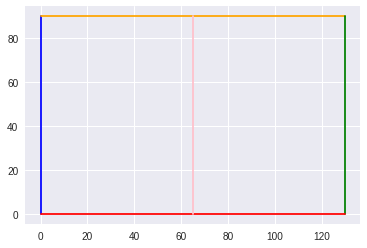

In [448]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)

plt.plot([0,0],[0,90], color="blue")
plt.plot([0,130],[90,90], color="orange")
plt.plot([130,130],[90,0], color="green")
plt.plot([130,0],[0,0], color="red")
plt.plot([65,65],[0,90], color="pink")

plt.show()

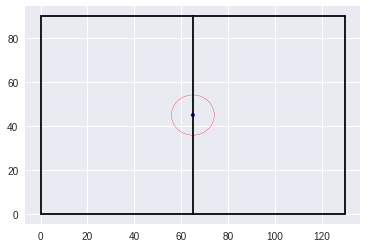

In [449]:


#Create figure
fig=plt.figure()
ax=fig.add_subplot(1,1,1)

#Pitch Outline & Centre Line
plt.plot([0,0],[0,90], color="black")
plt.plot([0,130],[90,90], color="black")
plt.plot([130,130],[90,0], color="black")
plt.plot([130,0],[0,0], color="black")
plt.plot([65,65],[0,90], color="black")

#Assign circles to variables - do not fill the centre circle!
centreCircle = plt.Circle((65,45),9.15,color="red",fill=False)
centreSpot = plt.Circle((65,45),0.8,color="blue")

#Draw the circles to our plot
ax.add_patch(centreCircle)
ax.add_patch(centreSpot)


plt.show()


NameError: name 'circles' is not defined

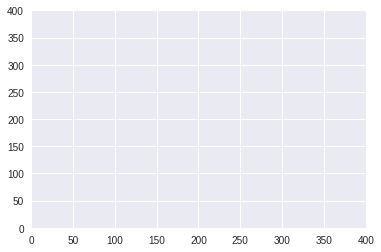

In [446]:
fig=plt.figure(1)
plt.axis([0,400,0,400])
ax=fig.add_subplot(1,1,1)
circles(0.5, 0.5, 0.2, c='g', ax=ax, facecolor='none', transform=ax.transAxes)
plt.show()

In [429]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

ValueError: setting an array element with a sequence.

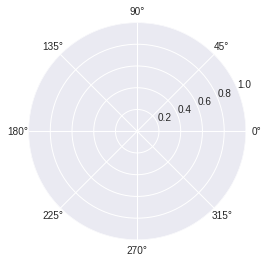

In [444]:
plt.matplotlib.pyplot.polar(unique_data_sample_pd_df[['POI_Coordinates']],unique_data_sample_pd_df[['DATA_Coordinates']])

In [441]:
def create_circle():
    circle= plt.Circle((0,0), radius= 5)
    return circle

In [442]:
def show_shape(patch):
    ax=plt.gca()
    ax.add_patch(patch)
    plt.axis('scaled')
    plt.show()

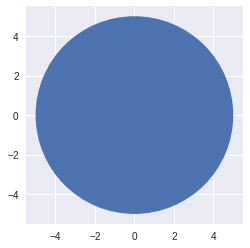

In [443]:
 if __name__== '__main__':
    c= create_circle()
    show_shape(c)
